In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wj2px0qb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wj2px0qb
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=1e4eb3574173d78a4e5c9faaeece920a9e38f33854d986238fbcdadfae809752
  Stored in directory: /tmp/pip-ephem-wheel-cache-goqqad0_/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-05-29 04:20:31--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

批量处理压缩包


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    # 等比例缩放并填充到目标尺寸，返回缩放比例和偏移
def resize_and_pad_image(image, target_size=(512, 512)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # 计算缩放比例，保持长宽比
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # 缩放图像
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 创建目标尺寸的黑色背景
    padded_image = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    # 计算填充位置（居中）
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    # 将缩放后的图像放在背景中心
    padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return padded_image, scale, x_offset, y_offset

# 将提示点从统一尺寸映射回原始图像
def map_points_to_original(points, scale, x_offset, y_offset, original_w, original_h):
    mapped_points = []
    for p in points:
        x_mapped = int((p[0] - x_offset) / scale)
        y_mapped = int((p[1] - y_offset) / scale)
        # 限制坐标在原始图像范围内
        x_mapped = max(0, min(x_mapped, original_w - 1))
        y_mapped = max(0, min(y_mapped, original_h - 1))
        mapped_points.append([x_mapped, y_mapped])
    return np.array(mapped_points)

# 获取 mask 的边界框
def get_mask_bbox(mask, padding=50):
    y, x = np.where(mask)
    if len(x) == 0 or len(y) == 0:
        return None
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(mask.shape[1], x_max + padding)
    y_max = min(mask.shape[0], y_max + padding)
    return x_min, y_min, x_max, y_max


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [7]:
# 寻找抬头Tprompt点位
from google.colab import files
uploaded = files.upload()

Saving mouth.zip to mouth.zip


In [8]:
import zipfile
import os

# 假设上传的是 my_images.zip
zip_filename ="mouth.zip"
angle_dir = "mouth"

# 解压缩
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(angle_dir)

print("解压完成，文件保存在：", angle_dir)

解压完成，文件保存在： mouth


In [8]:
root_dir = 'mouth'
# 输出裁剪后图像的目录
output_dir = 'output_mouth_images'
os.makedirs(output_dir, exist_ok=True)

# 记录没有 T 图像的文件夹
missing_T_folders = []

# def apply_mask(image):
#     """
#     示例 mask 裁剪函数（可以替换为你自己的 mask 裁剪方法）
#     这里演示使用简单的阈值操作。
#     """
#     image_np = np.array(image)
#     gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
#     _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
#     result = cv2.bitwise_and(image_np, image_np, mask=mask)
#     return Image.fromarray(result)

# 记录没有 T 图像的文件夹编号
missing_T_folders = []

# 遍历文件夹
for folder_name in sorted(os.listdir(root_dir), key=lambda x: int(x) if x.isdigit() else -1):
    folder_path = os.path.join(root_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    has_T = False
    for file in os.listdir(folder_path):
        if file.startswith('T') and file.lower().endswith(('.jpg', '.png', '.jpeg')):
            has_T = True
            break

    if not has_T:
        missing_T_folders.append(folder_name)

# 输出没有 T 图像的文件夹编号
print("📂 没有 T 图像的文件夹编号如下：")
print(missing_T_folders)
print(f"\n📊 总共没有 T 图像的文件夹数量：{len(missing_T_folders)}")

📂 没有 T 图像的文件夹编号如下：
[]

📊 总共没有 T 图像的文件夹数量：0


In [10]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


# 输入路径
root_dir = "mouth"
output_dir = "output_mouth_images"
os.makedirs(output_dir, exist_ok=True)

# 记录缺失 T 图像的编号
missing__mouth_folders = []

# ========= 3. 遍历 mouth 文件夹下的图片 =========
for file_name in os.listdir(root_dir):
    if not file_name.startswith("max_mar_frame_") or not file_name.endswith(".mp4.jpg"):
        continue

    # 提取编号验证
    try:
        number = int(file_name.replace("max_mar_frame_", "").replace(".mp4.jpg", ""))
    except ValueError:
        continue

    image_path = os.path.join(root_dir, file_name)
    print(f"🖼️ 处理图像：{image_path}")

    # Step 1. 读取图像
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ 无法读取图像: {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_h, original_w = image.shape[:2]
    predictor.set_image(image)

    # Step 2. 固定提示点（你可以自定义逻辑）
    target_size = (512, 512)
    input_points = np.array([[200,256],[256,200],[256,312],[256,256],[312,256]])
    input_labels = np.array([1,1,1,1,1])

    padded_image, scale, x_offset, y_offset = resize_and_pad_image(image, target_size)
    original_points = map_points_to_original(input_points, scale, x_offset, y_offset, original_w, original_h)

    # Step 3. 使用 SAM 模型生成 mask
    masks, scores, _ = predictor.predict(
        point_coords=original_points,
        point_labels=input_labels,
        multimask_output=True
    )

    # Step 4. 选择第二个 mask
    top_index = 1
    top_mask = masks[top_index]
    bbox = get_mask_bbox(top_mask, padding=50)

    if bbox is None:
        print(f"⚠️ 无法为 {folder_name} 提取有效 mask")
        continue

    x_min, y_min, x_max, y_max = bbox
    cropped_image = image[y_min:y_max+1, x_min:x_max+1]
    cropped_mask = top_mask[y_min:y_max+1, x_min:x_max+1]

    # Step 5. 将非 mask 区域置黑
    cropped_image[~cropped_mask] = [0, 0, 0]

    # Step 6. 缩放并填充为 512x512
    final_image, _, _, _ = resize_and_pad_image(cropped_image, target_size)

    # Step 7. 保存处理结果
    save_path = os.path.join(output_dir, f"output_mouth_{number}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
    print(f"✅ 已保存处理图像到: {save_path}")

# 打印缺失T图像的文件夹信息
print(f"\n📂 共缺失 T 图像的文件夹数量: {len(missing_T_folders)}")
print("这些文件夹编号如下：")
print(missing_T_folders)

🖼️ 处理图像：mouth/max_mar_frame_23.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_23.jpg
🖼️ 处理图像：mouth/max_mar_frame_7.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_7.jpg
🖼️ 处理图像：mouth/max_mar_frame_62.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_62.jpg
🖼️ 处理图像：mouth/max_mar_frame_320.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_320.jpg
🖼️ 处理图像：mouth/max_mar_frame_78.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_78.jpg
🖼️ 处理图像：mouth/max_mar_frame_291.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_291.jpg
🖼️ 处理图像：mouth/max_mar_frame_324.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_324.jpg
🖼️ 处理图像：mouth/max_mar_frame_410.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_410.jpg
🖼️ 处理图像：mouth/max_mar_frame_306.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_306.jpg
🖼️ 处理图像：mouth/max_mar_frame_392.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_mouth_392.jpg
🖼️ 处理图像：mouth/max_mar_frame_355.mp4.jpg
✅ 已保存处理图像到: output_mouth_images/output_m

NameError: name 'missing_T_folders' is not defined

In [11]:
import shutil

# 设定你要下载的文件夹路径和压缩后的文件名
folder_path = "output_mouth_images"  # 替换为你的文件夹路径
output_zip = "output_mouth_images.zip"

# 打包为 zip 文件
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', folder_path)
print("✅ 压缩完成")

✅ 压缩完成


In [12]:
from google.colab import files
files.download(output_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

处理单张图片

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    # 等比例缩放并填充到目标尺寸，返回缩放比例和偏移
def resize_and_pad_image(image, target_size=(512, 512)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # 计算缩放比例，保持长宽比
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # 缩放图像
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 创建目标尺寸的黑色背景
    padded_image = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    #padded_image = np.full((target_h, target_w, 3), 255, dtype=np.uint8)  # 白色背景

    # 计算填充位置（居中）
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    # 将缩放后的图像放在背景中心
    padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return padded_image, scale, x_offset, y_offset

# 将提示点从统一尺寸映射回原始图像
def map_points_to_original(points, scale, x_offset, y_offset, original_w, original_h):
    mapped_points = []
    for p in points:
        x_mapped = int((p[0] - x_offset) / scale)
        y_mapped = int((p[1] - y_offset) / scale)
        # 限制坐标在原始图像范围内
        x_mapped = max(0, min(x_mapped, original_w - 1))
        y_mapped = max(0, min(y_mapped, original_h - 1))
        mapped_points.append([x_mapped, y_mapped])
    return np.array(mapped_points)

# 获取 mask 的边界框
def get_mask_bbox(mask, padding=50):
    y, x = np.where(mask)
    if len(x) == 0 or len(y) == 0:
        return None
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(mask.shape[1], x_max + padding)
    y_max = min(mask.shape[0], y_max + padding)
    return x_min, y_min, x_max, y_max


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [6]:
# 寻找prompt点位并显示
from google.colab import files
uploaded = files.upload()

Saving max_mar_frame_115.mp4.jpg to max_mar_frame_115.mp4.jpg


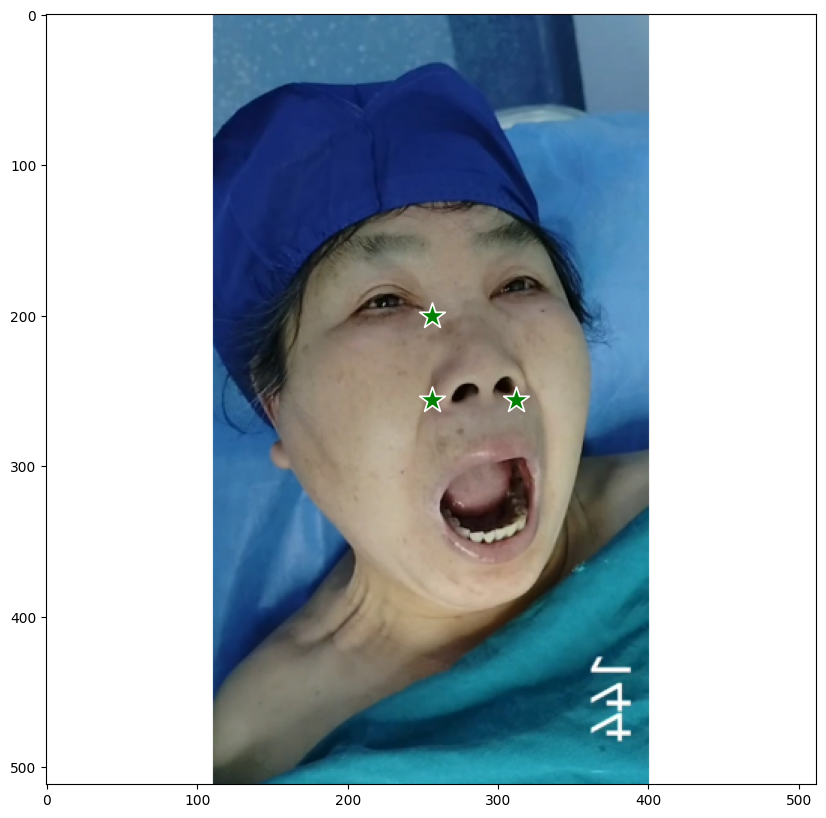

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 获取上传的文件名
filename = list(uploaded.keys())[0]

# 读取图片
image = cv2.imread(filename)
if image is None:
    raise ValueError(f"Failed to load image '{filename}'")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 设定目标尺寸
target_size = (512, 512)
fill_color = (255,255,255)  # 灰色填充边界，避免使用纯黑色

# 获取原始尺寸
h, w = image.shape[:2]
scale = min(target_size[0] / h, target_size[1] / w)
new_h, new_w = int(h * scale), int(w * scale)

# 等比例缩放
resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

# 计算边界填充量
pad_top = (target_size[0] - new_h) // 2
pad_bottom = target_size[0] - new_h - pad_top
pad_left = (target_size[1] - new_w) // 2
pad_right = target_size[1] - new_w - pad_left

# 边界填充
padded_image = cv2.copyMakeBorder(
    resized_image,
    pad_top, pad_bottom, pad_left, pad_right,
    borderType=cv2.BORDER_CONSTANT,
    value=fill_color
)

#############################################################
input_point = np.array([[256,200],[256,256],[312,256]])
input_label = np.array([1,1,1])
plt.figure(figsize=(10,10))
plt.imshow(padded_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

初始化SAM

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(padded_image)

original_h, original_w = image.shape[:2]



<ipython-input-16-2fdc0d3e7a72>:60: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-2fdc0d3e7a72>:60: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-2fdc0d3e7a72>:60: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-2fdc0d3e7a72>:60: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-2fdc0d3e7a72>:60: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-2fdc0d3e7a72>:60: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-2fdc0d3e7a72>:60: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from

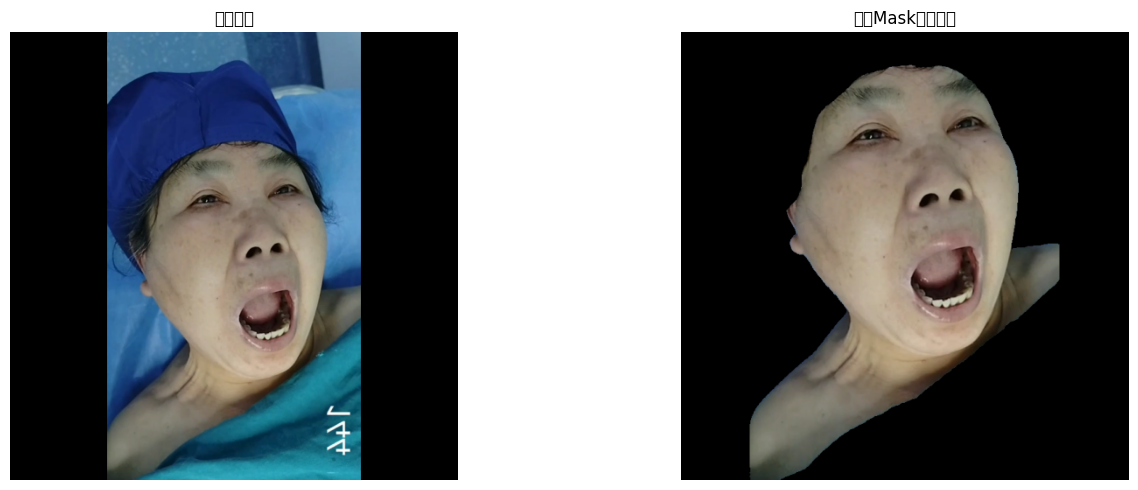

✅ 已保存处理图像为: output_T_265.jpg


In [16]:
# Step 1. 读取图像
image = cv2.imread(filename)
if image is None:
  print(f"❌ 无法读取图像: {filename}")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_h, original_w = image.shape[:2]
predictor.set_image(image)
#################################################################################
    # Step 2. 固定提示点（你可以自定义逻辑）
target_size = (512, 512)
input_points = np.array([[256,200],[256,256],[312,256],[400,200]])
input_labels = np.array([1,1,1,1])

padded_image, scale, x_offset, y_offset = resize_and_pad_image(image, target_size)
original_points = map_points_to_original(input_points, scale, x_offset, y_offset, original_w, original_h)

    # Step 3. 使用 SAM 模型生成 mask
masks, scores, _ = predictor.predict(
    point_coords=original_points,
    point_labels=input_labels,
    multimask_output=True
    )

    # Step 4. 选择第二个 mask
top_index = 1
top_mask = masks[top_index]
bbox = get_mask_bbox(top_mask, padding=50)

if bbox is None:
  print(f"⚠️ 无法为 {folder_name} 提取有效 mask")


x_min, y_min, x_max, y_max = bbox
cropped_image = image[y_min:y_max+1, x_min:x_max+1]
cropped_mask = top_mask[y_min:y_max+1, x_min:x_max+1]

    # Step 5. 将非 mask 区域置黑[000]白【255，255，255】
cropped_image[~cropped_mask] = [0,0,0]

    # Step 6. 缩放并填充为 512x512
final_image, _, _, _ = resize_and_pad_image(cropped_image, target_size)
# 可视化步骤
plt.figure(figsize=(15, 5))

# 原图
plt.subplot(1, 2, 1)
plt.imshow(padded_image)
plt.title("原始图像")
plt.axis("off")



# 最终处理图像
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title("应用Mask后的图像")
plt.axis("off")

plt.tight_layout()
plt.show()
####################################################################################33
save_path = "output_T_265.jpg"  # 固定文件名即可，不需要根据文件夹名动态生成
# 保存处理后的图像
cv2.imwrite(save_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
print(f"✅ 已保存处理图像为: {save_path}")


In [17]:
from google.colab import files
files.download(save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Example image

In [13]:
# 寻找prompt点位并显示
from google.colab import files
uploaded = files.upload()

Saving D.jpg to D.jpg


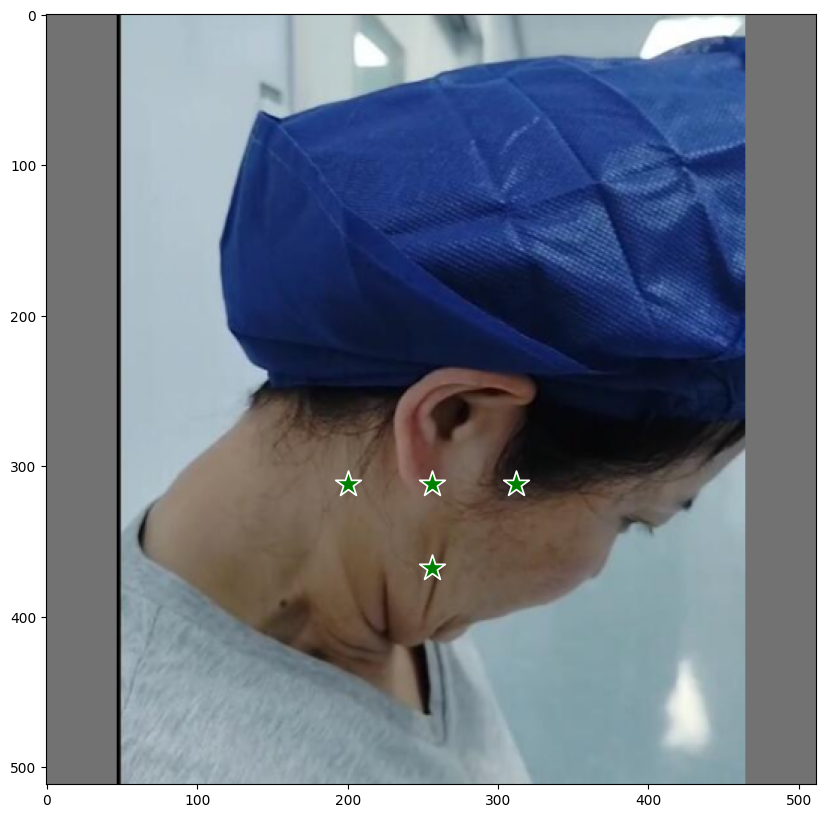

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 获取上传的文件名
filename = list(uploaded.keys())[0]

# 读取图片
image = cv2.imread(filename)
if image is None:
    raise ValueError(f"Failed to load image '{filename}'")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 设定目标尺寸
target_size = (512, 512)
fill_color = (114, 114, 114)  # 灰色填充边界，避免使用纯黑色

# 获取原始尺寸
h, w = image.shape[:2]
scale = min(target_size[0] / h, target_size[1] / w)
new_h, new_w = int(h * scale), int(w * scale)

# 等比例缩放
resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

# 计算边界填充量
pad_top = (target_size[0] - new_h) // 2
pad_bottom = target_size[0] - new_h - pad_top
pad_left = (target_size[1] - new_w) // 2
pad_right = target_size[1] - new_w - pad_left

# 边界填充
padded_image = cv2.copyMakeBorder(
    resized_image,
    pad_top, pad_bottom, pad_left, pad_right,
    borderType=cv2.BORDER_CONSTANT,
    value=fill_color
)


input_point = np.array([[200,312],[256,368],[256,312],[312,312]])
input_label = np.array([1,1,1,1])
plt.figure(figsize=(10,10))
plt.imshow(padded_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [19]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [20]:
predictor.set_image(padded_image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [21]:
input_point = np.array([[200,312],[256,368],[256,312],[312,312]])
input_label = np.array([1,1,1,1])

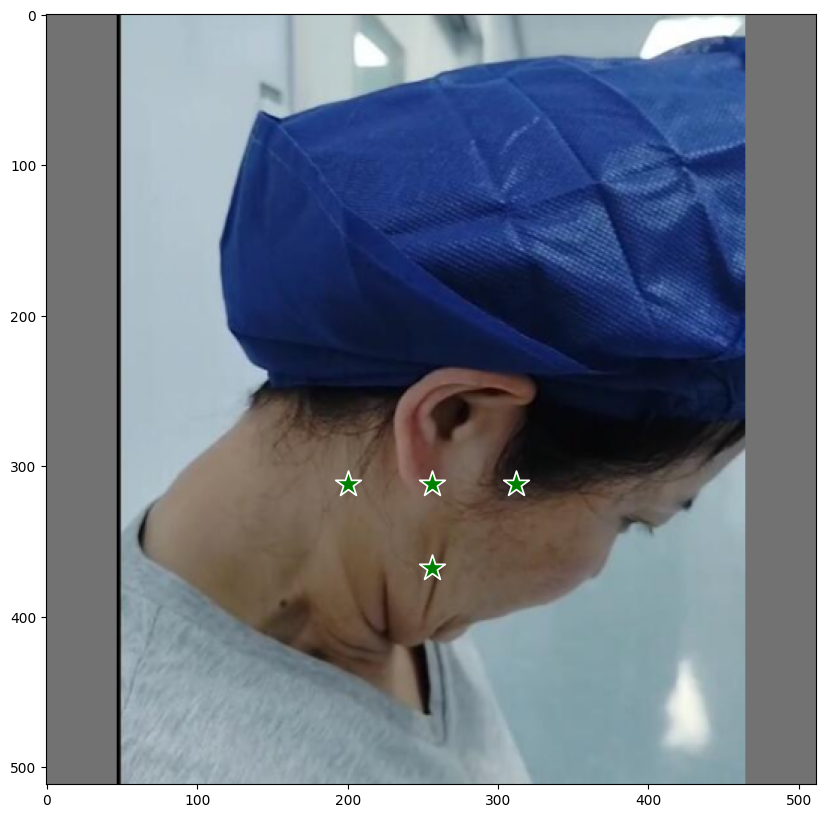

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(padded_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [23]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [24]:
masks.shape  # (number_of_masks) x H x W

(3, 512, 512)

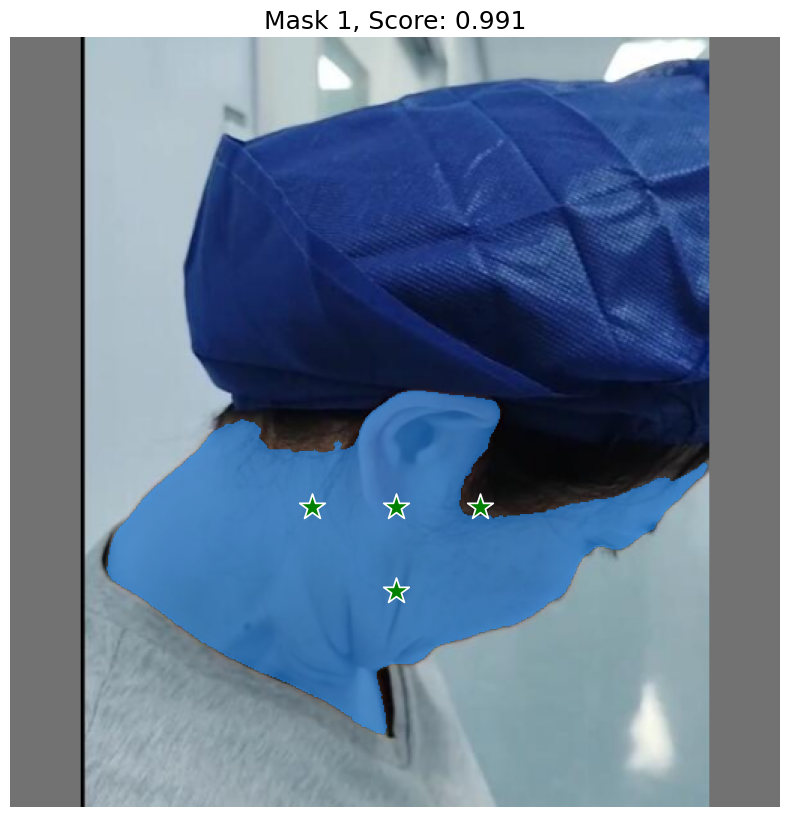

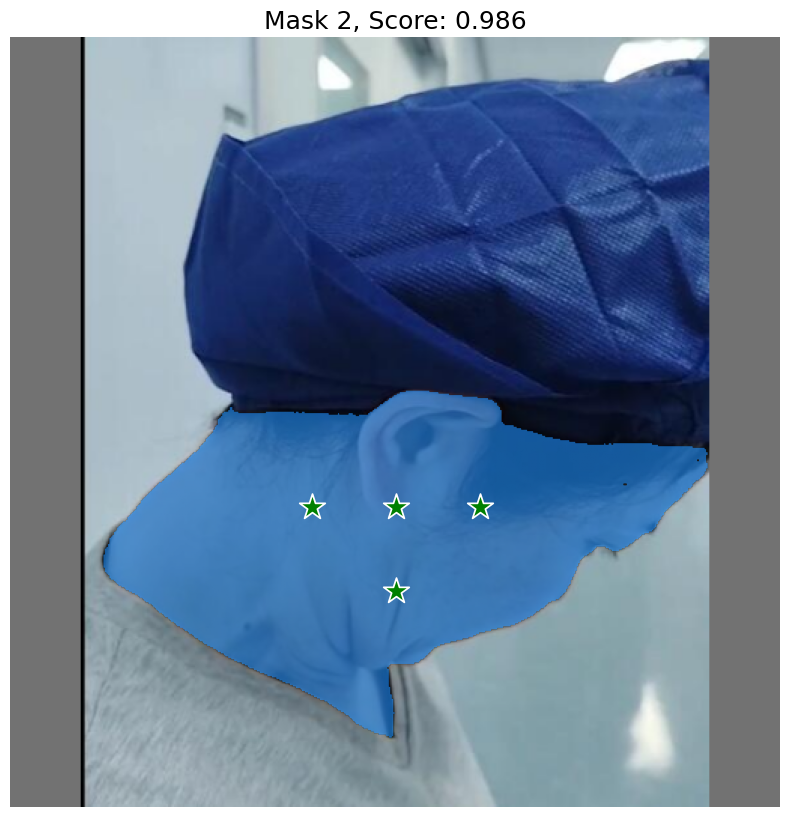

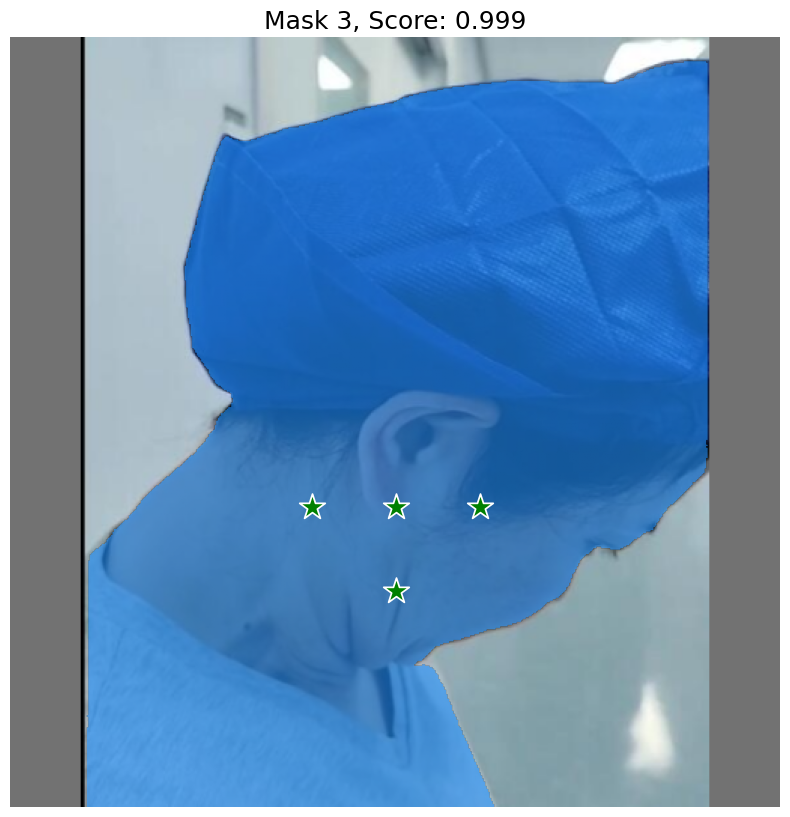

In [25]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(padded_image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

(1, 1200, 1800)

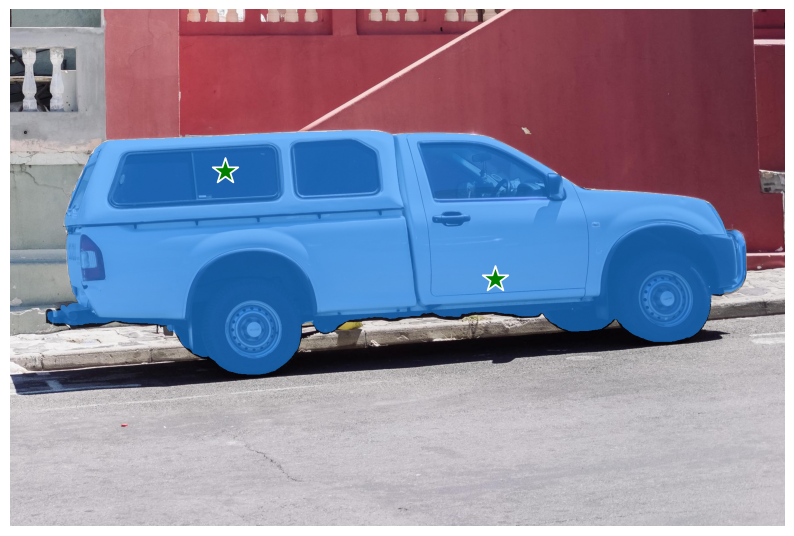

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

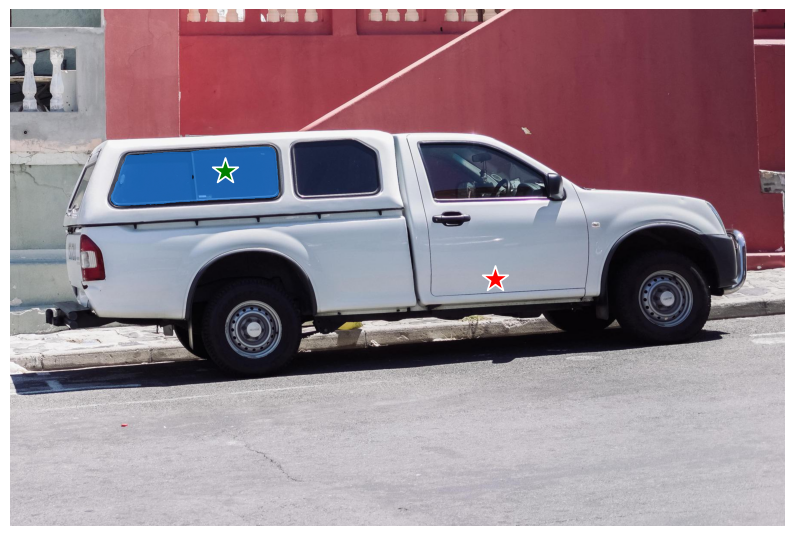

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

可视化transform带来的影响

In [5]:
from google.colab import files
uploaded = files.upload()

Saving 抬头.zip to 抬头.zip


In [9]:
import zipfile
import os

# 假设上传的是 my_images.zip
zip_filename ="抬头.zip"
angle_dir = "抬头"

# 解压缩
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(angle_dir)

print("解压完成，文件保存在：", angle_dir)

解压完成，文件保存在： 抬头


In [10]:
import os
from PIL import Image
from torchvision import transforms
import shutil

def augment_images_with_flip(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    flip_transform = transforms.RandomHorizontalFlip(p=1.0)  # 100% 翻转

    for filename in os.listdir(input_dir):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(input_dir, filename)
        image = Image.open(img_path).convert("RGB")

        # 保存原图
        shutil.copy2(img_path, os.path.join(output_dir, filename))

        # 翻转图像并保存
        flipped_image = flip_transform(image)
        name, ext = os.path.splitext(filename)
        flipped_name = f"{name}_flip{ext}"
        flipped_path = os.path.join(output_dir, flipped_name)
        flipped_image.save(flipped_path)

    print(f"✅ 图像扩充完成，输出路径：{output_dir}")

# 使用示例
if __name__ == "__main__":
    input_dir = "抬头"         # 替换为你的原始图像路径
    output_dir = "augmented_images"       # 扩充后图像的保存路径

    augment_images_with_flip(input_dir, output_dir)


✅ 图像扩充完成，输出路径：augmented_images


In [11]:
import shutil

# 设定你要下载的文件夹路径和压缩后的文件名
folder_path = "augmented_images"  # 替换为你的文件夹路径
output_zip = "augmented_images.zip"

# 打包为 zip 文件
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', folder_path)
print("✅ 压缩完成")

✅ 压缩完成


In [12]:
from google.colab import files
files.download(output_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F  # 用于原图 -> tensor 转换
# 获取上传的文件名
filename = list(uploaded.keys())[0]

# 读取图片
image = cv2.imread(filename)
if image is None:
    raise ValueError(f"Failed to load image '{filename}'")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


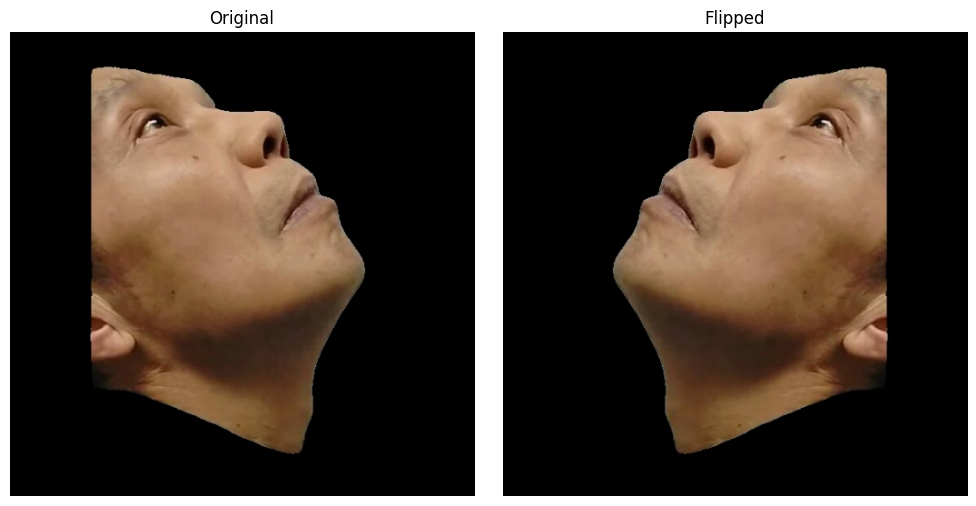

In [13]:


# 加载图片（替换为你的路径）

image = Image.open(filename).convert("RGB")

# 定义 transform（只加翻转）
flip_transform = transforms.RandomHorizontalFlip(p=1.0)  # 强制翻转用于对比

# 原图转 tensor 再转 numpy 显示
def tensor_to_numpy(img_tensor):
    img_tensor = img_tensor.clone().detach()
    img_tensor = img_tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                 torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img_tensor = img_tensor.clamp(0, 1)
    return img_tensor.permute(1, 2, 0).numpy()

# 可视化函数
def visualize_flip(image):
    import torch

    # 原图 -> tensor
    original_tensor = transforms.ToTensor()(image)

    # 归一化图像（和模型一致）
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    normalized_tensor = normalize(original_tensor)

    # 强制翻转
    flipped_tensor = flip_transform(normalized_tensor)

    # 反归一化并转为 numpy 图像
    original_np = tensor_to_numpy(normalized_tensor)
    flipped_np = tensor_to_numpy(flipped_tensor)

    # 显示
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_np)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(flipped_np)
    axes[1].set_title("Flipped")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# 可视化
visualize_flip(image)


## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
input_box = np.array([425, 600, 700, 875])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

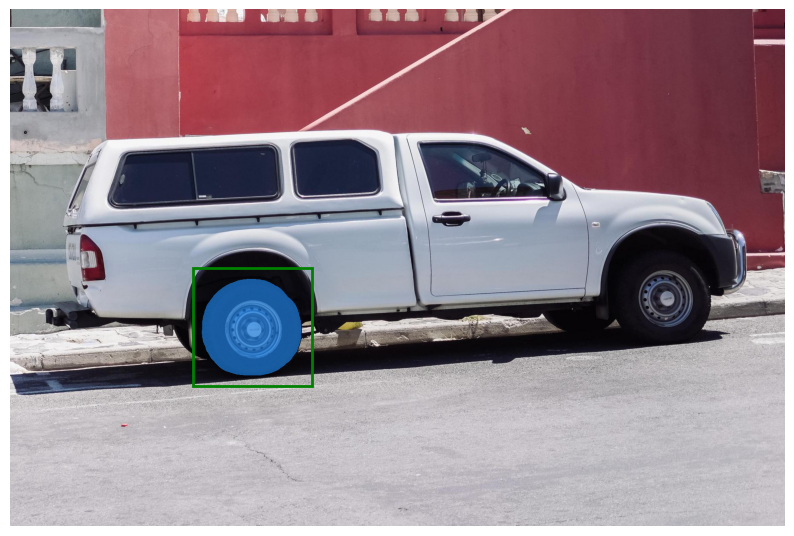

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [ ]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

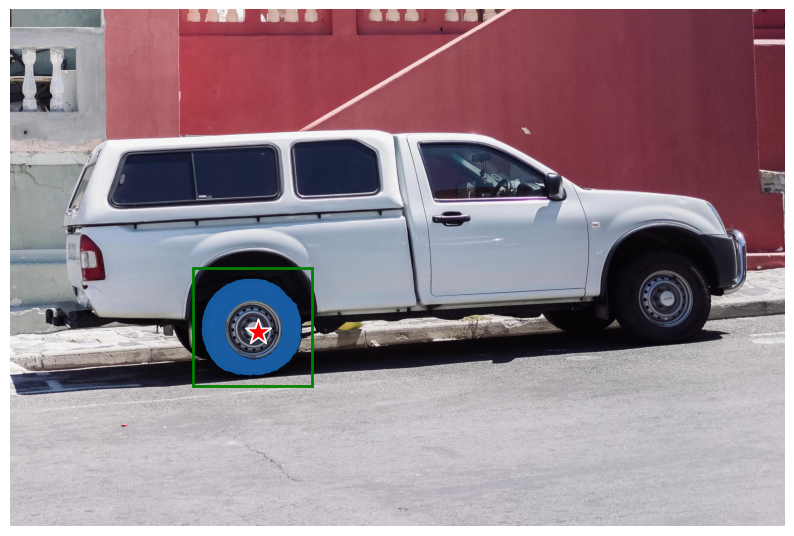

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [ ]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([4, 1, 1200, 1800])

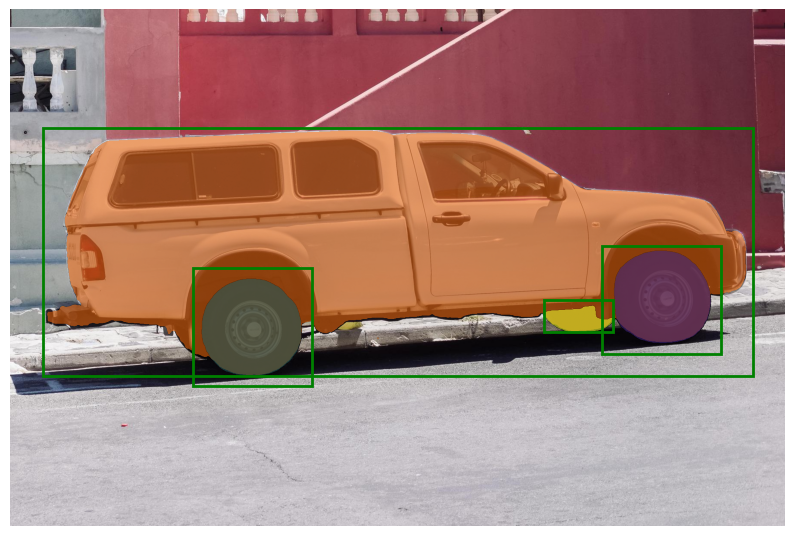

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device)
    return image.permute(2, 0, 1).contiguous()

In [ ]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

Run the model.

In [ ]:
batched_output = sam(batched_input, multimask_output=False)

The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [ ]:
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

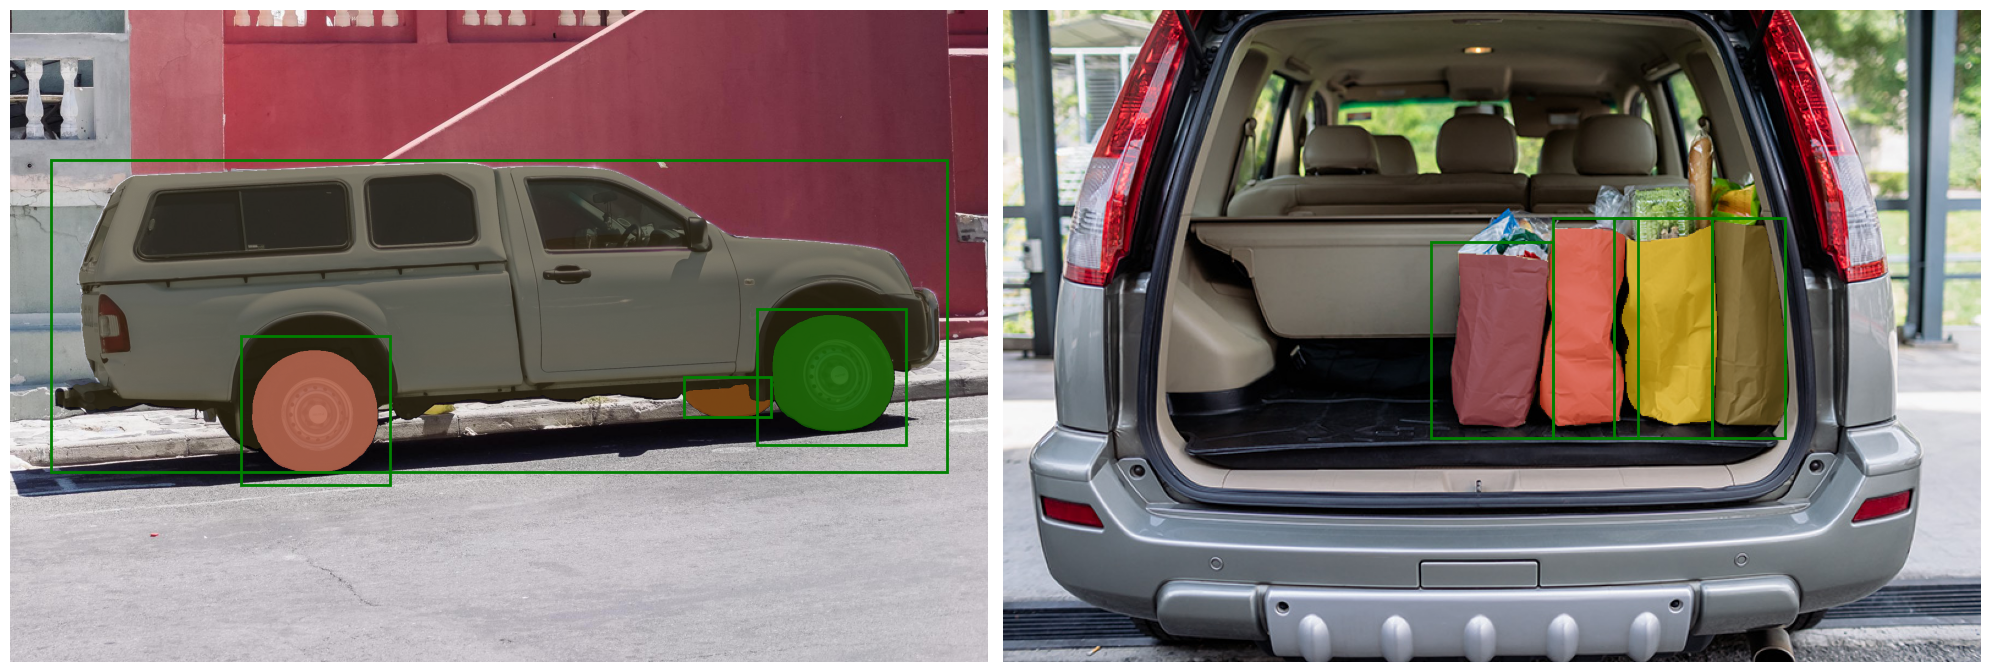

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()